In [1]:
import torch 
import torch.nn as nn 
import torchvision 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import os
import copy

In [2]:
TRAIN_DIR = './train'
TEST_DIR = './test'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Defining parameters:
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.1

In [5]:
val_test_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

train_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [8]:
def prepare_dataloaders(TRAIN_DIR, TEST_DIR, batch_size=BATCH_SIZE, val_split=VALIDATION_SPLIT):
    try:
        # Check if directories exist
        if not os.path.exists(TRAIN_DIR):
            raise FileNotFoundError("Train directory does not exist.")
        if not os.path.exists(TEST_DIR):
            raise FileNotFoundError("Test directory does not exist.")
    except Exception as e:
        print(f"Error: {e}")
        
    # Splitting dataset into training and validation sets
    full_train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=val_test_transform)
    test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=val_test_transform)
    
    val_size = int(val_split * len(full_train_dataset))
    train_size = len(full_train_dataset) - val_size

    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    
    # applying transformations to the datasets:
    train_subset_with_aug = copy.deepcopy(train_dataset.dataset)
    train_subset_with_aug.transform = train_transform
    train_dataset.dataset = train_subset_with_aug
    
    # calculating weights to tackle class imbalance:
    print('Calculating class weights...')
    train_labels = [full_train_dataset.targets[i] for i in train_dataset.indices]
    class_counts = torch.bincount(torch.tensor(train_labels))
    class_weights = 1. / class_counts.detach().clone()
    
    print(f"Detected class counts in training set: {class_counts}")
    print(f"Calculated class weights: {class_weights}")
    
    # creating dataloaders:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)        
    
    # printing dataset sizes:
    print("Data Preparation Completed...")
    print(f"Detected classes: {full_train_dataset.classes}\nNumber of training samples: {len(train_dataset)}\nNumber of validation samples: {len(val_dataset)}\n"
          f"Detected classes in test set: {test_dataset.classes}\nNumber of test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader, full_train_dataset.classes, test_dataset.classes, class_weights

In [9]:
try:
    train_loader, val_loader, test_loader, classes, test_classes, weights = prepare_dataloaders(TRAIN_DIR, TEST_DIR)
    weights = weights.to(device)
except Exception as e:
    print(f"An error occurred while preparing the data loaders: {e}")

Calculating class weights...
Detected class counts in training set: tensor([2980,  348, 3029, 5294, 4486, 4345, 2845])
Calculated class weights: tensor([0.0003, 0.0029, 0.0003, 0.0002, 0.0002, 0.0002, 0.0004])
Data Preparation Completed...
Detected classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of training samples: 23327
Number of validation samples: 2591
Detected classes in test set: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of test samples: 5266


## Defining CNN Model:

In [10]:
class EmotionClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionClassifier, self).__init__()
        
        # first convolutional layer - input: 1*48*48
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # output: 4*24*24
        )
        
        # second convolutional layer - input: 8*24*24
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # output: 8*12*12
        )
        
        # third convolutional layer - input: 8*12*12
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # output: 16*6*6
        )
        
        # fourth convolutional layer - input: 16*6*6
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # output: 32*3*3
        )
        
        # fully connected layer
        self.fc1 = nn.Sequential(
            nn.Linear(32*3*3, 512),  # input: 32*3*3, output: 512
            nn.ReLU(),
            nn.Dropout(0.5),              # output: 512
            nn.Linear(512, num_classes)  # output: num_classes (default 7 for emotions)
        )
        
        
    def forward(self, x):
        
        # Forward pass through the convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Flatten the output for the fully connected layer
        x = x.view(-1, 32*3*3)
        
        # Forward pass through the fully connected layer for classification
        x = self.fc1(x)
        
        return x

## Training the model:

In [11]:
# Hyperparameters
LEARNING_RATE = 0.00025
EPOCHS = 50

In [12]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [13]:
model = EmotionClassifier(num_classes=len(classes))
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0025)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

In [14]:
# Recording the training process
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [15]:
# Training loop:
print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    
    # Initialize variables to track loss and accuracy per epoch
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backpropagation and weight update
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()
        optimizer.step()
        
        # calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct_train / total_train
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
        
    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct_val / total_val
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss
    
    # printing epoch results
    print(f"Epoch [{epoch+1}/{EPOCHS}], \n"
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%, \n"
          f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%"
          f"\n\n")
    
print("Training completed!")

Starting training...
Epoch [1/50], 
Train Loss: 1.9004, Train Accuracy: 22.99%, 
Val Loss: 1.8149, Val Accuracy: 33.73%


Epoch [2/50], 
Train Loss: 1.7893, Train Accuracy: 30.09%, 
Val Loss: 1.7671, Val Accuracy: 28.79%


Epoch [3/50], 
Train Loss: 1.7395, Train Accuracy: 32.56%, 
Val Loss: 1.7005, Val Accuracy: 34.04%


Epoch [4/50], 
Train Loss: 1.6846, Train Accuracy: 34.69%, 
Val Loss: 1.6611, Val Accuracy: 38.87%


Epoch [5/50], 
Train Loss: 1.6527, Train Accuracy: 36.43%, 
Val Loss: 1.6359, Val Accuracy: 39.64%


Epoch [6/50], 
Train Loss: 1.6213, Train Accuracy: 37.70%, 
Val Loss: 1.5969, Val Accuracy: 38.83%


Epoch [7/50], 
Train Loss: 1.5979, Train Accuracy: 38.57%, 
Val Loss: 1.6173, Val Accuracy: 35.74%


Epoch [8/50], 
Train Loss: 1.5701, Train Accuracy: 39.46%, 
Val Loss: 1.5535, Val Accuracy: 42.61%


Epoch [9/50], 
Train Loss: 1.5583, Train Accuracy: 40.28%, 
Val Loss: 1.5534, Val Accuracy: 40.56%


Epoch [10/50], 
Train Loss: 1.5411, Train Accuracy: 40.68%, 
Val Loss:

In [16]:
with open('results.txt', 'w') as f:
    f.write("Training and Validation Results:\n")
    for epoch in range(EPOCHS):
        f.write(f"Epoch {epoch+1}: Train Loss: {train_losses[epoch]:.4f}, "
                f"Train Accuracy: {train_accuracies[epoch]:.2f}%, "
                f"Val Loss: {val_losses[epoch]:.4f}, "
                f"Val Accuracy: {val_accuracies[epoch]:.2f}%\n")

In [17]:
model.eval()

correct_test = 0
total_test = 0

class_correct = [0] * len(test_classes)
class_total = [0] * len(test_classes)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        c = (predicted == labels).squeeze()
            
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

print("\n--- Per-Class Accuracy ---")
for i in range(len(test_classes)):
    if class_total[i] > 0:
        print(f'Accuracy of {classes[i]:<10s}: {100 * class_correct[i] / class_total[i]:.2f} %')
    else:
        print(f'Accuracy of {classes[i]:<10s}: N/A (no samples)')
    
    

Test Accuracy: 51.18%

--- Per-Class Accuracy ---
Accuracy of angry     : 38.87 %
Accuracy of disgust   : 64.58 %
Accuracy of fear      : 19.86 %
Accuracy of happy     : 70.11 %
Accuracy of neutral   : 54.06 %
Accuracy of sad       : 38.61 %
Accuracy of surprise  : 75.81 %


In [18]:
preds = []
labels = []

model.eval()
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        label = label.to(device)
        
        # forward pass
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        preds.extend(predicted.cpu().numpy())
        labels.extend(label.cpu().numpy())


--- Classification Report ---
              precision    recall  f1-score   support

       angry       0.39      0.39      0.39       705
     disgust       0.12      0.65      0.21        48
        fear       0.34      0.20      0.25       720
       happy       0.76      0.70      0.73      1328
     neutral       0.24      0.54      0.33       357
         sad       0.53      0.39      0.45      1277
    surprise       0.67      0.76      0.71       831

    accuracy                           0.51      5266
   macro avg       0.44      0.52      0.44      5266
weighted avg       0.54      0.51      0.52      5266



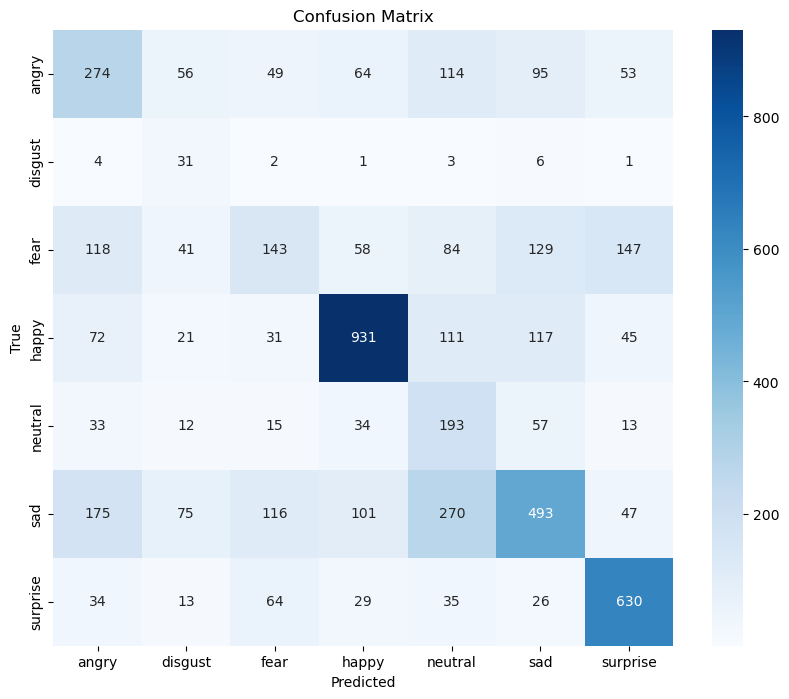

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
print("\n--- Classification Report ---")
print(classification_report(labels, preds, target_names=test_classes))

cm = confusion_matrix(labels, preds)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_classes, yticklabels=test_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



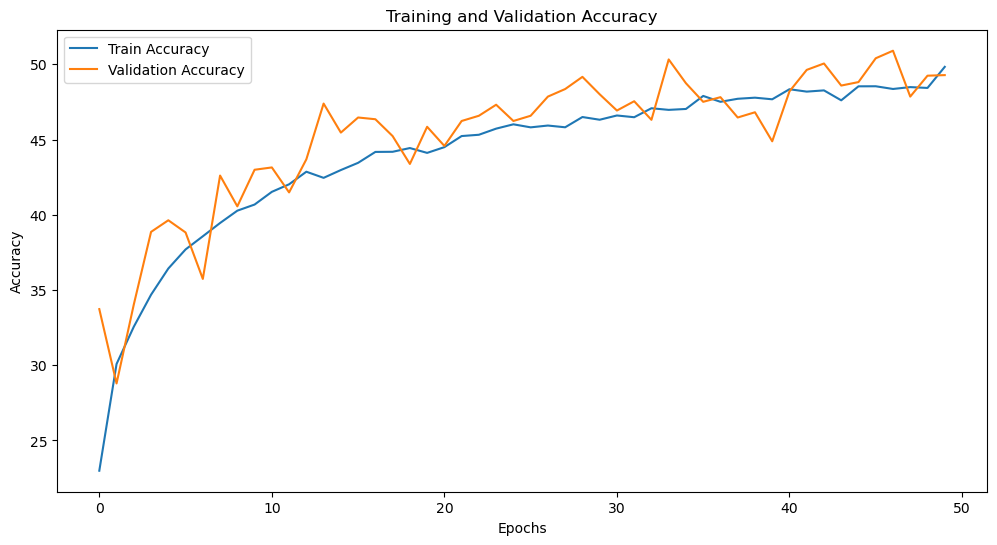

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

It's accuracy stopped increasing after around 25 epochs.